### CNN for Assamese characters

The data for the Assamese characters have been taken from this [UCI respository](https://archive.ics.uci.edu/ml/datasets/Online+Handwritten+Assamese+Characters+Dataset#). There are about 8326 images corresponding to various letters, combined letters (*zuktakkhor*) and numbers. The original data has not contain images but instead consist of lines and strokes used for writing each alphabet. This will not be useful for character recognition and thus I have converetd the data into images and categorised the data into train and test sets which will make it easier to use Keras for classification. As a first trial I will be using a Convolutional Neural Network to test the accuracy.

Assamese is the Eastern most of the Indo-European group of languages. Like Hindi there are letters can be combined to form compound alphabets. The dataset contains almost all such combinations and we thus have around 183 classes. This leads to only around 50 images per class which is less than it is desired. This is the only existing extensive set of handwritten Assamese characters.

We will be using Keras in this notebook as it is the easiest to implement and test a neural network. 

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import metrics
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

%matplotlib inline

In [217]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape=(50, 50, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))
model.add(Dropout(0.25))

#model.add(Conv2D(64, (3, 3), activation = 'relu'))
#model.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding = 'same'))
model.add(Dropout(0.25))

# the model so far outputs 3D feature maps (height, width, features)

# dense layer
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(500, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(183, activation = 'softmax'))

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In order to have nicer convergence it will be best to employ a learning rate that will decrease with epoch. At higher epoch the loss does not reduce significantly and we can explore the loss region more efficiently by reducing the learning rate. 

In [218]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [219]:
batch_size = 30

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=False)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(50, 50),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=(50, 50),
        batch_size=batch_size,
        class_mode='categorical')

model.summary()

Found 6563 images belonging to 183 classes.
Found 1649 images belonging to 183 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 9, 9, 64)          18496     
______________________________________________________

In [220]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=130,
        validation_data=validation_generator,
        validation_steps=1000 // batch_size)
model.save_weights('first_try.h5')


Epoch 1/130
66/66 [==============================] - 3s 41ms/step - loss: 5.2182 - acc: 0.0015 - val_loss: 5.2100 - val_acc: 0.0051
Epoch 2/130
66/66 [==============================] - 2s 33ms/step - loss: 5.2076 - acc: 0.0071 - val_loss: 5.1963 - val_acc: 0.0152
Epoch 3/130
66/66 [==============================] - 2s 31ms/step - loss: 5.1647 - acc: 0.0116 - val_loss: 5.0614 - val_acc: 0.0354
Epoch 4/130
66/66 [==============================] - 2s 34ms/step - loss: 4.9095 - acc: 0.0359 - val_loss: 4.5573 - val_acc: 0.0910
Epoch 5/130
66/66 [==============================] - 2s 31ms/step - loss: 4.5508 - acc: 0.0717 - val_loss: 4.2262 - val_acc: 0.1153
Epoch 6/130
66/66 [==============================] - 2s 31ms/step - loss: 4.1819 - acc: 0.1035 - val_loss: 3.6045 - val_acc: 0.1980
Epoch 7/130
66/66 [==============================] - 2s 33ms/step - loss: 3.8967 - acc: 0.1399 - val_loss: 3.3825 - val_acc: 0.2700
Epoch 8/130
66/66 [==============================] - 2s 31ms/step - loss: 3.

66/66 [==============================] - 2s 33ms/step - loss: 0.4672 - acc: 0.8554 - val_loss: 0.4086 - val_acc: 0.8677
Epoch 124/130
66/66 [==============================] - 2s 35ms/step - loss: 0.4641 - acc: 0.8490 - val_loss: 0.3819 - val_acc: 0.8847
Epoch 125/130
66/66 [==============================] - 2s 32ms/step - loss: 0.4334 - acc: 0.8599 - val_loss: 0.3753 - val_acc: 0.8807
Epoch 126/130
66/66 [==============================] - 2s 34ms/step - loss: 0.5048 - acc: 0.8419 - val_loss: 0.3351 - val_acc: 0.8889
Epoch 127/130
66/66 [==============================] - 2s 36ms/step - loss: 0.4876 - acc: 0.8505 - val_loss: 0.4656 - val_acc: 0.8564
Epoch 128/130
66/66 [==============================] - 2s 32ms/step - loss: 0.4537 - acc: 0.8529 - val_loss: 0.3627 - val_acc: 0.8879
Epoch 129/130
66/66 [==============================] - 2s 33ms/step - loss: 0.4536 - acc: 0.8621 - val_loss: 0.4286 - val_acc: 0.8615
Epoch 130/130
66/66 [==============================] - 2s 33ms/step - loss: 

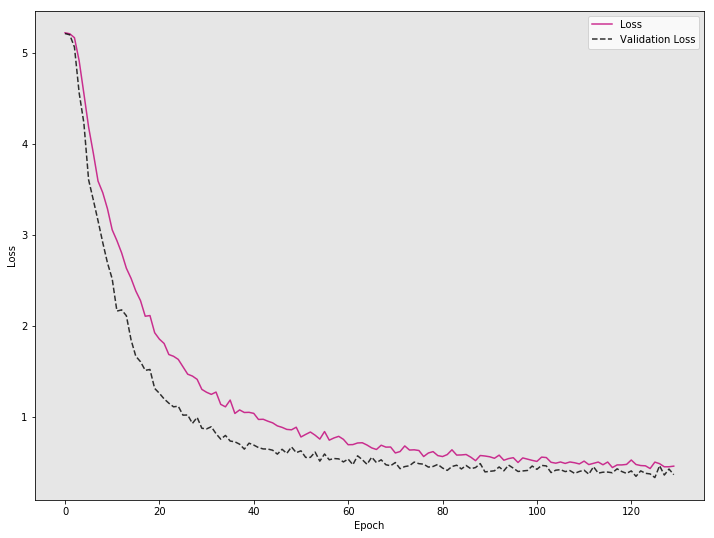

In [221]:
fig, ax = plt.subplots(1,1, figsize = (12,9))
ax.plot(history.history['loss'], '-', color = 'xkcd:magenta', label = 'Loss', alpha = 0.8)
ax.plot(history. history['val_loss'], '--', color = 'xkcd:black', label = 'Validation Loss', alpha = 0.8)
ax.legend(loc = 'best')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_facecolor('0.9')

In [222]:
predict_generator = test_datagen.flow_from_directory(
                'data/test',
                target_size=(50, 50),
                batch_size=1650,
                class_mode='categorical', shuffle = False)
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#Predict the output
y_pred = model.predict_generator(predict_generator)
#y_pred_classes
y_pred_classes = np.argmax(y_pred, axis = 1)

#y true values

y_true = validation_generator.classes

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred_classes)

Found 1649 images belonging to 183 classes.


In [223]:
accuracy = cm.trace()/cm.sum()

In [224]:
print('The overall accuracy is: {}% '.format(accuracy*100))

The overall accuracy is: 87.62886597938144% 


In [338]:
#plt.figure(figsize = (20, 20))
#plot_confusion_matrix(cm[:50,:50], classes = range(50)) 

I am plotting just the first 50 of the classes in order to demonstrate how the confusion matrix looks like.

In [225]:
x = train_generator.class_indices

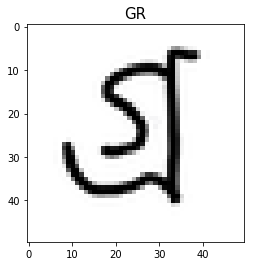

In [347]:
from resizeimage import resizeimage
def predict_new_image(path):
        test1 = load_img(path)
        test2 = resizeimage.resize_contain(test1, [50,50]).convert('RGB')
        test = img_to_array(test2)
        test = np.expand_dims(test, axis = 0)
        result = model.predict(test)
        x = train_generator.class_indices
        all_label = list(x.keys())
        plt.figure()
        plt.clf()
        plt.imshow(test2, cmap = 'Greys')
        plt.title(all_label[result.argmax()], fontsize = 15)
predict_new_image('predict/predict_7.jpg')

C:\Users\nathd\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=[<tf.Tenso...)`
  This is separate from the ipykernel package so we can avoid doing imports until


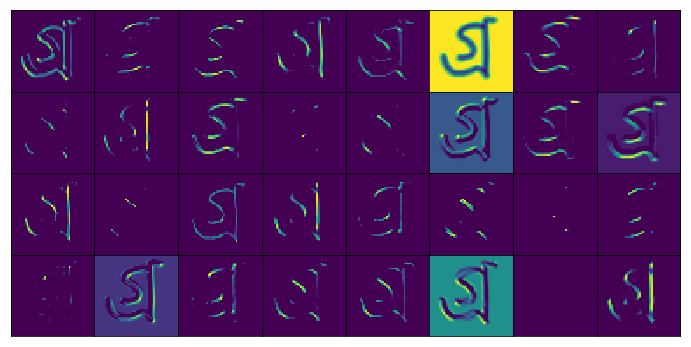

In [348]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(input=model.input, output=layer_outputs)
test1 = load_img('predict/predict_7.jpg')
test2 = resizeimage.resize_contain(test1, [50,50]).convert('RGB')
test = img_to_array(test2)
test = np.expand_dims(test, axis = 0)
activations = activation_model.predict(test)

first_layer_activation = activations[0]
fig = plt.figure(figsize = (12, 6))
for i in range(first_layer_activation.shape[3]):
    ax = plt.subplot(4, 8, i+1)
    ax.imshow(first_layer_activation[0, :, :, i], cmap='viridis')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')
fig.subplots_adjust(wspace=0, hspace=0)   
  


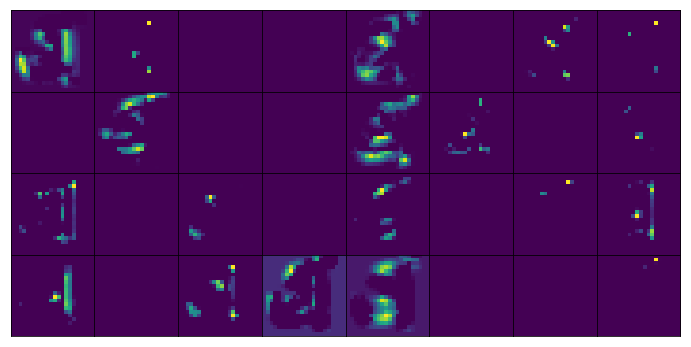

In [349]:
second_layer_activation = activations[2]
fig = plt.figure(figsize = (12, 6))
for i in range(second_layer_activation.shape[3]):
    ax = plt.subplot(4, 8, i+1)
    ax.imshow(second_layer_activation[0, :, :, i], cmap='viridis')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')
fig.subplots_adjust(wspace=0, hspace=0)  

In [350]:
model.layers

In [351]:
activations[5].shape

(1, 9, 9, 64)

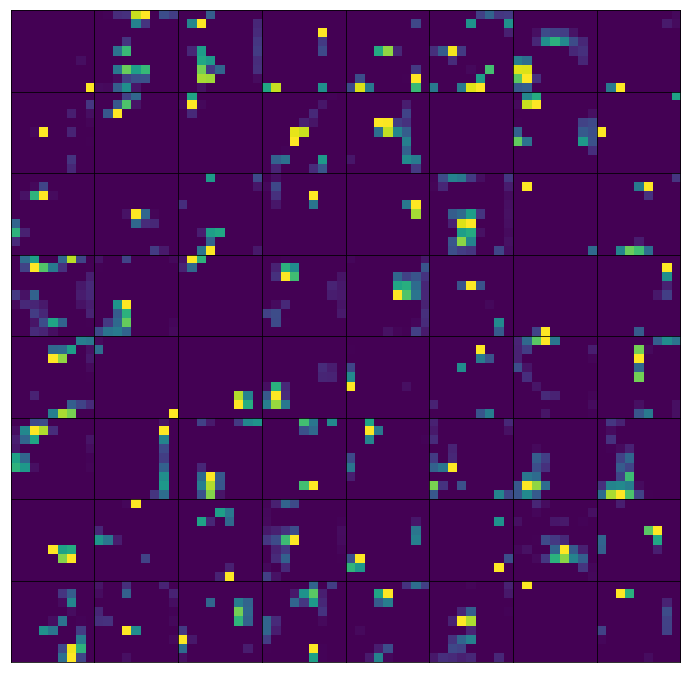

In [352]:
third_conv_activation = activations[5]
fig = plt.figure(figsize = (12, 12))
for i in range(third_conv_activation.shape[3]):
    ax = plt.subplot(8, 8, i+1)
    ax.imshow(third_conv_activation[0, :, :, i], cmap='viridis')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')
fig.subplots_adjust(wspace=0, hspace=0)  

I have displayed the outputs of the various Convolution layers to get an idea of how the various layers look like. We can see how the various filters look like. This filters as we can see helps us various features which in turn are used for classification.

### Conclusion
In this notebook, we have seen that even with less data with CNN we are able to classify and predict Assamese characters with over 88 % accuracy. The number of classes was pretty high as we numbers, alphabets and composite characters were also included. In the future, a capsule net can be implemented, as it is works better with less data and large number of classes.